## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

## Generate Molecules

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from net import *
from utils import *
from custom_dataset import *

if torch.cuda.is_available():
    torch.cuda.empty_cache() #empty cache
    print('CUDA Version')
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')
    print('\n')

##hardware params
# DEVICE = torch.device('cpu') #DEBUG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: \n', DEVICE)

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 

CUDA Version
CUDNN Version: 90100
Number of CUDA Devices: 2
Active CUDA Device: 0
Available devices: 2, Name: NVIDIA RTX A4000
Current CUDA device: 0


Using Device: 
 cuda


#### Hyperparameters

In [2]:
##OS
LINUX = True
MULTI_GPU = True #trains using multiple gpus
N_PROCESSORS = max_processors - 2

##data
HOLDOUT_PERC = 0.90
TRAIN_BS = 128 #train batch size
PREFETCH_FACTOR = 4 #effectively reduces gpu load time 
NUM_WORKERS = 8

##training
N_EPOCHS = 500 #num of training epochs
OPTIMIZER = 'rmsprop' ##or adam
LRG = 0.004086800025392213 #learning rate generator
LRD = 0.013448070902660135 #learning rate discriminator
LRS_SZ = 5 #learning rate scheduler step size
LRS_GAMMA = 0.99 #learning rate scheduler gamma
BETAS = (0.5, 0.999) #momentum moving average
DROPOUT_PROB = 0.5 #dropout
WEIGHT_DECAY = 1e-5 #L2 Regularization
RUN_EXTRA_TIMES = 3 #iterate over validator extra times for every one time that the generator ates
EMBEDDING_DIM = 32 #how large of a vector to represent input data
HIDDEN_DIM = 128 #learned embeddings
N_LAYERS = 2 #num gru layers
BIDIRECTIONAL = True #makes gru layer bidirectional
N_HEADS = 4 #number of heads for attention, scaled dot-product for head's respective section of sequence
CLIP_VALUE = 0.008101987508250374 ##WGAN discriminator clip value for training stabalization

##inference
N_SAMPLES = 1000
MAX_LENGTH = 10

##visualization params
SIGMA = 2 #loss smoothing for lineplot
PRINT_LOSS_EVERY = 2 #how many epochs to output loss

##logging
RESULTS_PATH = '../results/'
BEST_GEN_NET_PATH = RESULTS_PATH + 'epoch_1_exper_at_datetime_23-08-2024_20-13-44/gnet.pt'
WRITEPATH = RESULTS_PATH + 'infererence/'
make_dir(WRITEPATH)

Created Folder at:  ../results/infererence/


#### Open SMILES Data

In [3]:
%%time

### Import the data
data_file = pd.read_csv('../data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()

# ##split dset
# train_smiles, holdout_smiles, _, _ = train_test_split(smilesList, smilesList, test_size=HOLDOUT_PERC, random_state=42)
# print('Len all smiles: ', len(smilesList))
# print('Len train smiles: ', len(train_smiles))
# print('Len holdout smiles: ', len(holdout_smiles))

print('\n')



CPU times: user 135 ms, sys: 10.7 ms, total: 146 ms
Wall time: 146 ms


In [4]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('Data Summary: ')
print('smilesList Len: ', len(smilesList))
print('vocab len: ', len(vocab))
print('max_length: ', max_length)
print('\n')

Data Summary: 
smilesList Len:  249456
vocab len:  254593
max_length:  27


CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 636 ms


### Instantiate GAN and Discriminator Networks

In [5]:
%%time

##init Generator networks
n_gen = Generator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=N_LAYERS, max_length=max_length, 
                  num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

print('\nTotal generator param cnt: ', count_parameters(n_gen))
print('Trainable generator param cnt: ', count_trainable_parameters(n_gen))

##check if was run in parallel and generate new state dict
state_dict = torch.load(BEST_GEN_NET_PATH, map_location=torch.device(DEVICE))
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.'):
        new_key = key[len('module.'):]
    else:
        new_key = key
    new_state_dict[new_key] = value

n_gen.load_state_dict(new_state_dict)

print('\n')


Total generator param cnt:  74261698
Trainable generator param cnt:  74261698


CPU times: user 1.13 s, sys: 578 ms, total: 1.71 s
Wall time: 2.1 s


In [6]:
n_gen

Generator(
  (embedding): Embedding(254594, 32)
  (gru): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=254594, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Generate Molecules Using Trained GAN Generator 

In [7]:
%%time

gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=MAX_LENGTH, device=DEVICE)

print('\n')



CPU times: user 18.8 s, sys: 382 ms, total: 19.2 s
Wall time: 19.3 s


### Check Validity

In [8]:
%%capture

valid_smiles, invalid_smiles = check_smiles_validity(gen_smiles)

### Check Novelty

In [9]:
%%time

known_can_smiles = process_smiles_in_parallel(smiles_list=smilesList, function_object=canonicalize_smiles, n_processors=N_PROCESSORS)
print('\nLen known canonical smiles: ', len(known_can_smiles))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nChecking Novelty of Unique GAN Generated Samples')
novel_smiles = [] 
for smiles in list(set(valid_smiles)):
    can_smiles = canonicalize_smiles(smiles)
    if is_novel(can_smiles, known_can_smiles):
        novel_smiles.append(smiles)

print('\nNovel Cnt: ', len(novel_smiles))
print('\n----------------------Novel Smiles----------------------')
for i, smiles in enumerate(novel_smiles):
    print(f'\n{i}. {smiles}')
print('\n')


Len known canonical smiles:  249456

Checking Novelty of Unique GAN Generated Samples

Novel Cnt:  16

----------------------Novel Smiles----------------------

0. COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1

1. Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1

2. CCOc1cc(N2CCOCC2)c(OCC)cc1NC(=O)c1cccn1CCCOc1cc(N2CCOCC2)c(OCC)cc1NC(=O)c1cccn1CCCOc1cc(N2CCOCC

### Get Summary Stats

In [10]:
%%time

print("\n\n==================================================Stats==================================================")
basic_stats = summary_stats(valid_smiles, invalid_smiles)

print("\n\n===============================================Valid SMILES===============================================")
for i, smiles in enumerate(list(set(valid_smiles))):
    print(f'\n{i}.  {smiles}')

print("\n\n===============================================Inalid SMILES===============================================")
for i, smiles in enumerate(list(set(invalid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print('\n')



==================================================Stats==================================================
total generated cnt:  1000
valid cnt:  232
invalid Count:  768
unique valid cnt:  16
unique invalid cnt:  74
percent unique valid:  1.6
percent unique invalid:  7.4
ratio unique_valid/unique_invalid:  0.22


===============================================Valid SMILES===============================================

0.  COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1COc1cc(Br)ccc1S(=O)(=O)NCc1cccnc1

1.  Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2)cc1Cc1ccc(/C=C/C(=O)NNC(=O)c2cccc(Cl)c2

### Visualize GAN Generated Molecules

CPU times: user 157 ms, sys: 3.44 ms, total: 160 ms
Wall time: 160 ms


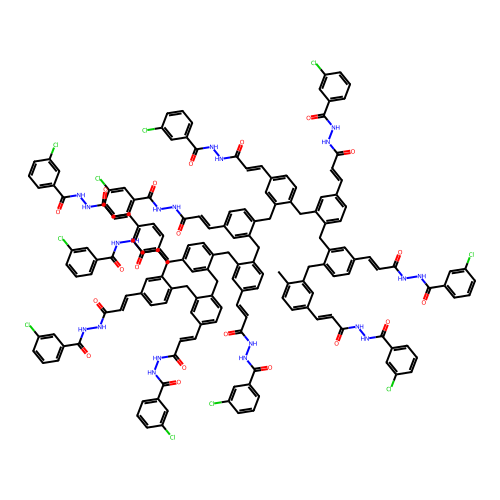

In [11]:
%%time

##plot a single example
img = plot_single_mol(list(set(valid_smiles))[1])
img.save(WRITEPATH + '/GAN_generated_img.png')
img

CPU times: user 1.01 s, sys: 102 µs, total: 1.01 s
Wall time: 1 s


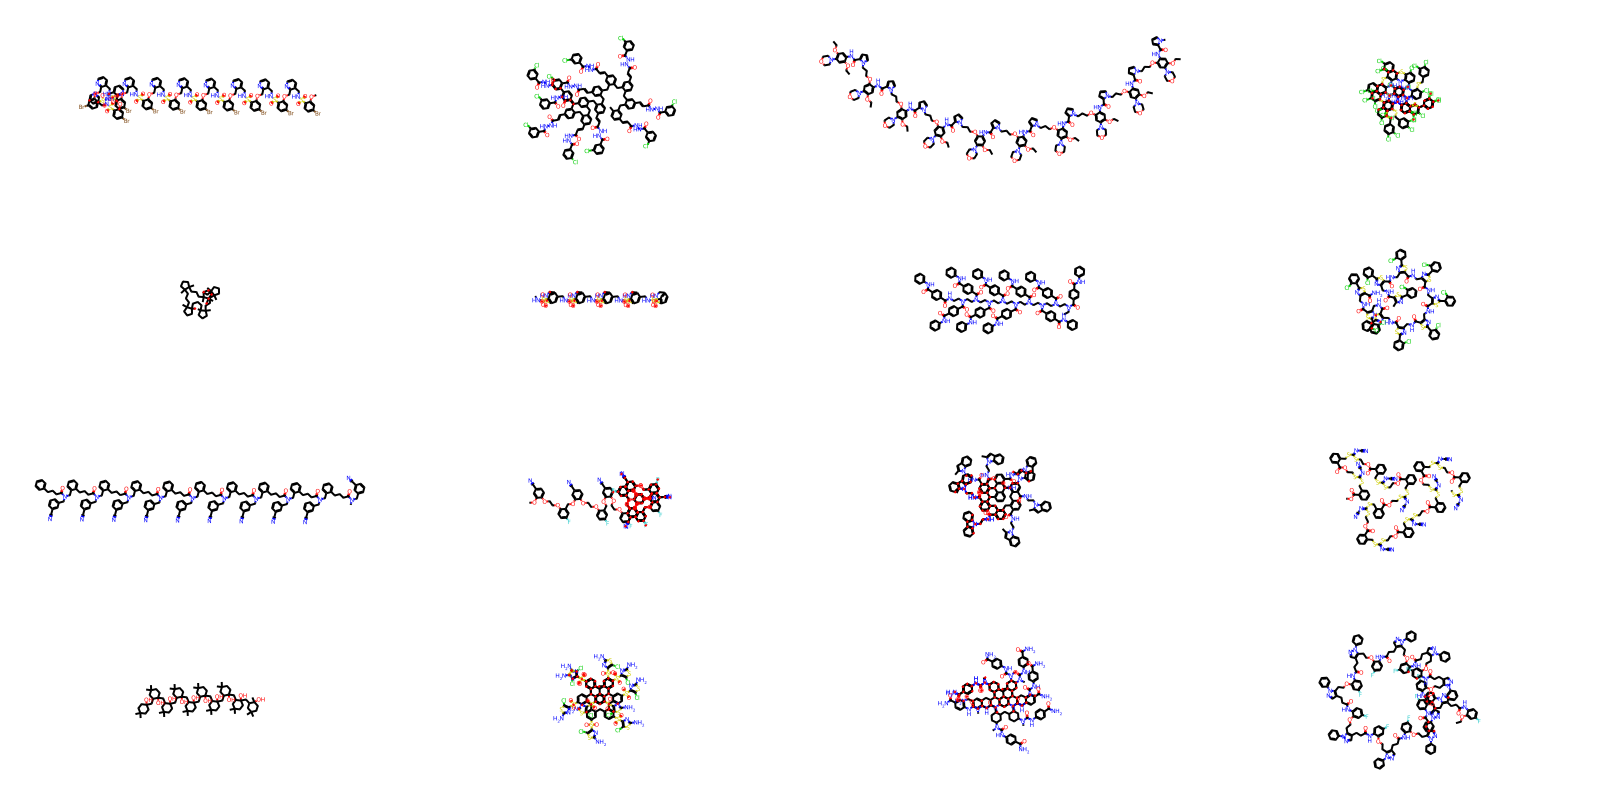

In [12]:
%%time

grid_img = plot_smiles_grid(smiles_list=list(set(valid_smiles)))
with open(WRITEPATH + "/grid_gan_generated.png", "wb") as f:
    f.write(grid_img.data)

grid_img

In [13]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  31.138
